# FAST demo

### This demo provides a simple illustration of the FAST algorithm for educational purposes. 
#### Details of FAST can be found in the following references: Yoon et al. (2015) Science Advances; Bergen & Beroza (2018a) GJI; Bergen & Beroza (2018b), PAGEOPH; Rong et al. (2018), PVLDB; Yoon et al. (2019), BSSA.
####   1)  This version of FAST is * NOT fast! * -- it is optimized for simplicity, not for speed.
####   2)  This version of FAST * may contain bugs that are not in the official FAST code release *  (this code was written from scratch in a couple of days and is independent of other implementations of FAST)

### Load libraries

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import time
import os

from scipy.signal import spectrogram, get_window
from scipy.sparse import coo_matrix
from skimage.transform import resize
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read
from scipy.spatial.distance import jaccard
from scipy.signal import find_peaks

from collections import defaultdict

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Set FAST parameters

In [2]:
# data
minfreq = 2
maxfreq = 8

# fingerprints
spec_winlen = 10.0
spec_winlag = 0.1
fp_winlen = 10.0
fp_winlag = 1.0
fp_dims = [32, 64]
K = 400

# similarity search
ntabl = 100
nfunc = 4
fp_nearrepeat = 10

plt.rcParams.update({'font.size': 16})

### Load single-channel seismic data

In [3]:
datafile = 'GFZ.CX.BHZ.PSGCX.2014-03-28T02.26.14.0.Iquique.sac'
event_list = [UTCDateTime("2014-03-28T02:26:14.0"), UTCDateTime("2014-03-28T02:32:16.0")] #[1131974, 1132336] 

if os.path.isfile(datafile):
    
    st = read(datafile, debug_headers=True)
    
else:    
    client = Client("GFZ")
    network = "CX"
    channel = "BHZ"
    station = "PSGCX"
    t0 = event_list[0]
    dt = 60*20
    dt0 = 60*10

    # requests data from FDSN server
    st = client.get_waveforms(network=network, station=station, location="*", channel=channel, starttime=t0 - dt0, endtime=t0 + dt)

    # save data to file
    st.write(datafile, format='SAC') 

#### Data preprocessing

In [4]:
# filter data
st.detrend(type='linear')
st.filter(type='bandpass', freqmin=minfreq, freqmax=maxfreq)

# single-channel seismic time series
x_trace = st[0].data
t_trace = st[0].times()
sampling_rate = st[0].stats.sampling_rate

#### Plot continuous data

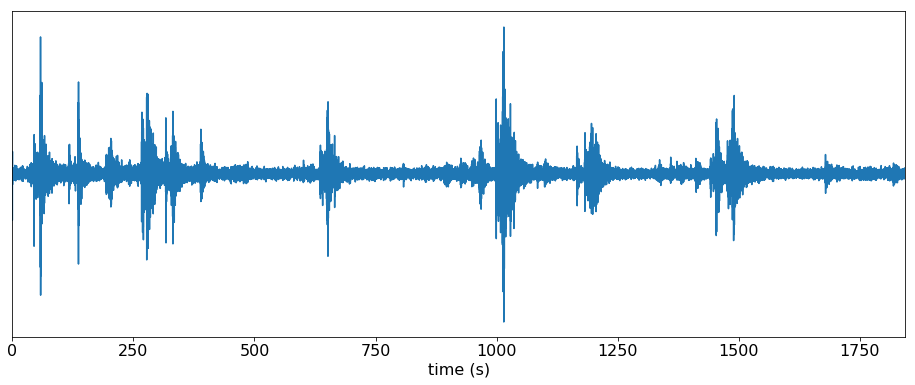

In [5]:
plt.figure(figsize=(16,6))
plt.plot(t_trace, x_trace)
plt.xlim([t_trace[0], t_trace[-1]])
plt.xlabel('time (s)')
plt.ylim([-1.1*np.max(np.abs(x_trace)), 1.1*np.max(np.abs(x_trace))])
plt.yticks([])
plt.show()

#### Plot pair of similar event waveforms (we will recover these events with FAST)

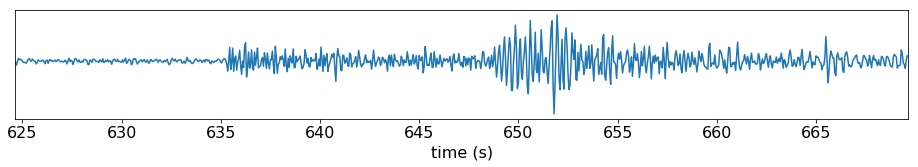

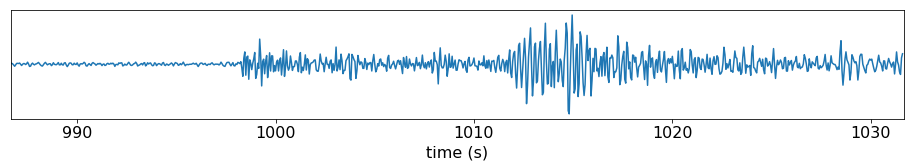

In [6]:
for event in event_list:
    idx1 = int((event - st[0].stats.starttime)*sampling_rate)
    plt.figure(figsize=(16,2))
    plt.plot(t_trace[idx1:idx1+int(45*sampling_rate)], x_trace[idx1:idx1+int(45*sampling_rate)])
    plt.xlabel('time (s)')
    plt.xlim([t_trace[idx1], t_trace[idx1+int(45*sampling_rate)]])
    plt.yticks([])
    plt.show()

## FEATURE EXTRACTION 

### Compute Spectrograms

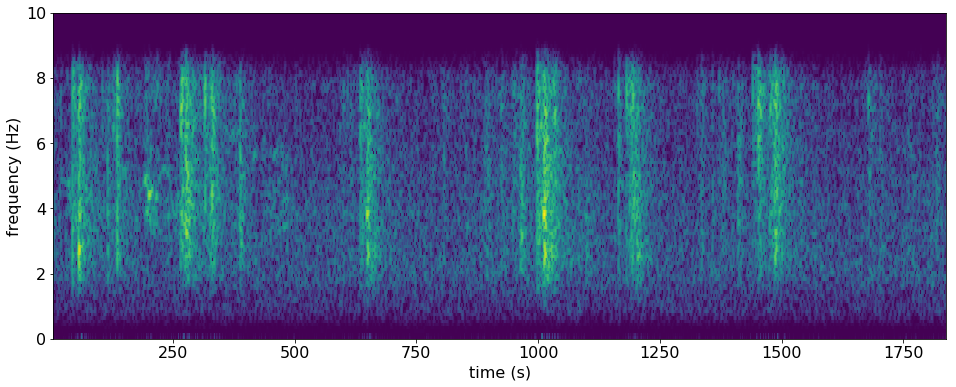

In [7]:
rtime = time.time()
fasttime = list()
f1, tt1, Sxx1 = spectrogram(x_trace,
                            fs=sampling_rate,
                            window=get_window('hann', int(sampling_rate*spec_winlen)),
                            nperseg=int(sampling_rate*spec_winlen),
                            noverlap=int(sampling_rate*(spec_winlen-spec_winlag)))
fasttime.append(time.time() - rtime) 

# plot spectrogram
plt.figure(figsize=(16,6))
plt.imshow(np.log(Sxx1 + 0.01), aspect='auto', extent=[tt1[0], tt1[-1], f1[0], f1[-1]], origin='lower')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.show()

#### Clip spectrogram frequencies

In [8]:
Sxx1 = Sxx1[(f1 <= maxfreq) & (f1 >= minfreq), :]
f1 = f1[(f1 <= maxfreq) & (f1 >= minfreq)]

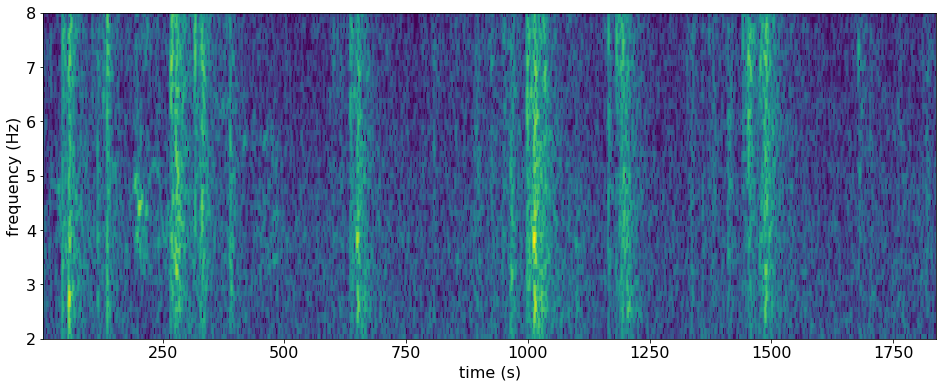

In [9]:
# plot spectrogram - clipped
plt.figure(figsize=(16,6))
plt.imshow(np.log(Sxx1 + 0.01), aspect='auto', extent=[tt1[0], tt1[-1], f1[0], f1[-1]], origin='lower')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.show()

### Extract Features from Spectrogram

#### Spectrogram rolling window parameters

In [10]:
wlen = int(fp_winlen / spec_winlag)
wlag = int(fp_winlag / spec_winlag)
N = int(np.floor((Sxx1.shape[1] - wlen) / wlag))

#### Function definitions: Feature extraction

In [11]:
maxlevel = pywt.dwt_max_level(data_len=np.min(fp_dims), filter_len=pywt.Wavelet('haar').dec_len)

def discrete_2d_wavelet(S, levels):
    c = pywt.wavedec2(S, 'haar', mode='constant', level=levels)
    W, _= pywt.coeffs_to_array(c)
    c[0] /= np.abs(c[0]).max()
    for i in range(levels):
        c[i + 1] = [x / np.abs(x).max() for x in c[i + 1]]
    W_norm, _ = pywt.coeffs_to_array(c)
    return W, W_norm
    
def extract_features(Sxx, tt, N, K, fp_dims, wlen, wlag, levels):
    
    spec_images = np.zeros((N, fp_dims[0], fp_dims[1]))
    haar_images = np.zeros((N, fp_dims[0], fp_dims[1]))
    haar_norm = np.zeros((N, fp_dims[0], fp_dims[1]))
    topK_haar = np.zeros((N, fp_dims[0]*fp_dims[1]),dtype=np.int8)
    binary_fp_bool = np.zeros((N, fp_dims[0]*fp_dims[1]*2), dtype=bool)
    binary_fp = np.zeros((N, K), dtype=np.int16)
    spec_t = np.zeros(N)
    
    for i in range(N):
        # select sliding window, resize to fp_dims
        S = Sxx[:, i*wlag:(i*wlag + wlen)]  # select sliding window
        S = resize(S, (fp_dims[0], fp_dims[1]), anti_aliasing=True)  # resize
        S /= np.linalg.norm(S.flatten()) # normalize
        spec_images[i, :, :] = S
        # haar wavelet transform        
        W, W_norm = discrete_2d_wavelet(S, levels)
        haar_images[i, :, :] = W
        haar_norm[i, :, :] = W_norm
        # select top K coefficients
        W_norm = W_norm.flatten()
        topK_idx = np.argpartition(np.abs(W_norm), -K)[-K:]  # index of top K coefficients
        #  keep sign, convert to binary fingerprint
        topK_sign = np.concatenate((2 * topK_idx[np.sign(W_norm[topK_idx]) > 0], 2 * topK_idx[np.sign(W_norm[topK_idx]) < 0] + 1))  # positive -> 10, negative -> 01
        topK_sign.sort()   
        topK_haar[i, topK_idx] = np.sign(W_norm[topK_idx])
        spec_t[i] = tt[i*wlag + int(wlen/2)]  # timestamp
        binary_fp_bool[i, topK_sign] = True
        binary_fp[i, :] = topK_sign
    
    return binary_fp, spec_t, (spec_images, haar_images, haar_norm, topK_haar, binary_fp_bool)

### Extract Binary Fingerprints

In [12]:
# note: only binary_fp and spec_t are used in similarity search, other outputs for visualization/debugging only
rtime = time.time()

binary_fp, spec_t, (spec_images, haar_images, haar_norm, topK_haar, binary_fp_bool) = extract_features(Sxx1, tt1, N, K, fp_dims, wlen, wlag, maxlevel)

fasttime.append(time.time() - rtime) 
print("runtime (feature extraction, %d fingerprints): %2.5f" % (N, fasttime[0] + fasttime[1]))  

runtime (feature extraction, 1823 fingerprints): 2.41216


#### Visualize feature extraction steps

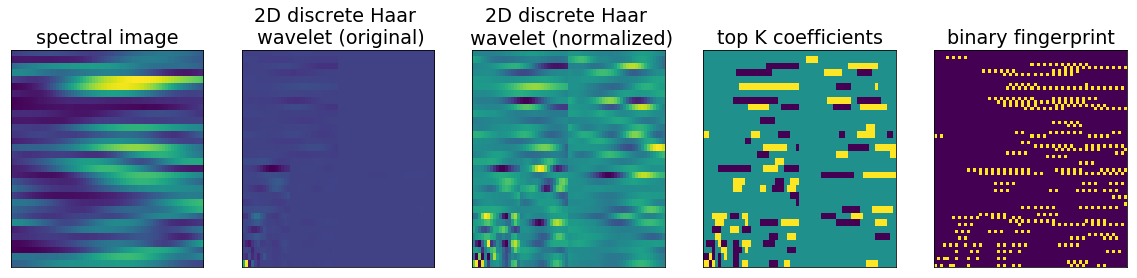

In [13]:
data_idx = 915

f, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].imshow(np.log(spec_images[data_idx,:,:] + 0.01), aspect='auto', origin='lower')
ax[0].set_title('spectral image')
ax[1].imshow(haar_images[data_idx,:,:], aspect='auto', origin='lower')
ax[1].set_title('2D discrete Haar \n wavelet (original)')
ax[2].imshow(haar_norm[data_idx,:,:], aspect='auto', origin='lower')
ax[2].set_title('2D discrete Haar \n wavelet (normalized)')
ax[3].imshow(topK_haar[data_idx,:].reshape(fp_dims[0], fp_dims[1]), aspect='auto', vmin=-1, vmax=1, origin='lower')
ax[3].set_title('top K coefficients')
ax[4].imshow(binary_fp_bool[data_idx,:].reshape(2*fp_dims[0], fp_dims[1]),aspect='auto', vmin=0, vmax=1, origin='lower')
ax[4].set_title('binary fingerprint')
for axis in ax:
    axis.set_yticks([])
    axis.set_xticks([])

## SIMILARITY SEARCH

### Generate random permutations 

In [14]:
max_value = fp_dims[0]*fp_dims[1]*2  # 4096, 8192
large_prime = 4099 # next largest prime value 4099 for fp_dim = [32,64], 8209 for fp_dim = [64,64] 

rseed = 123456
nperm = ntabl * nfunc

#  get random permutations
rtime = time.time()
g = np.random.RandomState(rseed)
perm_a, perm_b = np.array([(g.randint(1, large_prime, dtype=np.uint32),
                          g.randint(0, large_prime, dtype=np.uint32))
                         for z in range(nperm)], dtype=np.uint32).T

fasttime.append(time.time() - rtime)
print("runtime (generating permutations, %d hash functions): %2.5f" % (nperm, fasttime[-1]))  

runtime (generating permutations, 400 hash functions): 0.00130


### Compute MinHash Signatures
#### Permutation of x:  p(x) = (a*x + b) mod q  (for integers a, b, prime q)

In [15]:
# compute MinHash signatures
rtime = time.time()
MHS = np.zeros((N, ntabl*nfunc), dtype=np.int16)

for fp_idx in range(N):  # for each fingerprint
    for i in range(ntabl*nfunc): # for each hash function
        permuted_fp = ((binary_fp[fp_idx, :].astype(np.int32)*perm_a[i] + perm_b[i]) % large_prime).astype(np.int16)  # permute
        MHS[fp_idx, i] = np.min(permuted_fp)  # take minimum value

fasttime.append(time.time() - rtime)        
print("runtime (generating hash signatures, %d hash functions): %2.5f" % (nperm, fasttime[-1]))          

runtime (generating hash signatures, 400 hash functions): 7.77504


### Compare similarity MinHash signatures to Jaccard similarity (computed exactly)

#### This runs slowly (this is the point of FAST -- brute force computation of pairwise similarities is slow, scales quadratically with data duration). If number of fingerprints N is large, set M to a smaller value!

In [16]:
# check minhash signatures (for first M fingerprints in data set)
M = np.min((N, 2000)) 
jaccard_sim = np.zeros((M, M))
MHS_sim = np.zeros((M, M))

# exact Jaccard similarity
rtime = time.time()
for i in range(M-1):
    for j in range(i+1, M-1):
        jaccard_sim[i, j] = 1 - jaccard(binary_fp_bool[i, :], binary_fp_bool[j, :])
        # jaccard_sim[idx] = np.sum(binary_fp_bool[i, :] & binary_fp_bool[j, :]) / np.sum((binary_fp_bool[i, :] | binary_fp_bool[j, :]))

exacttime = time.time() - rtime        
print("runtime (Jaccard similarity, %d fingerprints): %2.5f" % (M, exacttime))

# similarity of MinHash signatures
for i in range(M-1):
    for j in range(i+1, M-1):
        MHS_sim[i, j] = np.sum(MHS[i, :] == MHS[j, :]) / (ntabl*nfunc)

runtime (Jaccard similarity, 1823 fingerprints): 44.27185


#### Plot MinHash signature similarity vs. Jaccard similarity 

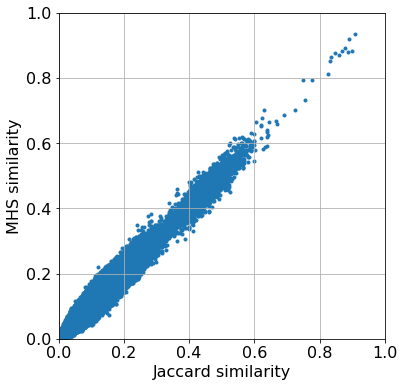

In [17]:
# plot as scatterplot
xi = np.triu(jaccard_sim).flatten()
yi = np.triu(MHS_sim).flatten()
plt.figure(figsize=(6,6))
plt.scatter(xi, yi, marker='.')
plt.xlim([0, 1])
plt.xlabel('Jaccard similarity')
plt.ylim([0, 1])
plt.ylabel('MHS similarity')
plt.axes().set_aspect('equal')
plt.grid(True, zorder=0)
plt.show()

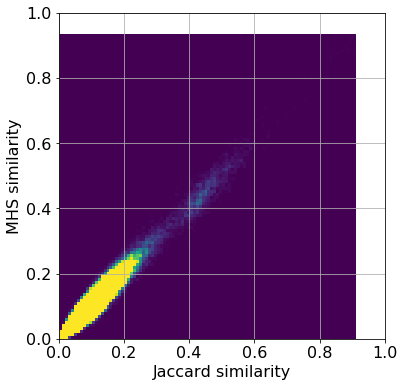

In [18]:
# plot as heatmap
heatmap, xedges, yedges = np.histogram2d(xi, yi, bins=K/4)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(6,6))
plt.imshow(heatmap.T, extent=extent, origin='lower',vmin=0, vmax=100)
plt.xlim([0, 1])
plt.xlabel('Jaccard similarity')
plt.ylim([0, 1])
plt.ylabel('MHS similarity')
plt.axes().set_aspect('equal')
plt.grid(True, zorder=0)
plt.show()

### Build hash tables for similarity search

In [19]:
nbits = int(np.ceil(np.log2(K)))

rtime = time.time()
fp_database = [defaultdict(list) for x in range(ntabl)]

for fp_idx in range(N):
    for tbl in range(ntabl):
        signature = MHS[fp_idx, (nfunc*tbl):(nfunc*(tbl+1))]
        hkey = np.sum(signature << (nbits * np.arange(nfunc)))
        fp_database[tbl][hkey].append(fp_idx)
        
fasttime.append(time.time() - rtime)        
print("runtime (building index, %d fingerprints, %d hash tables): %2.5f" % (N, ntabl, fasttime[-1]))        

runtime (building index, 1823 fingerprints, 100 hash tables): 1.26762


### Search Hash tables for similar waveforms

In [20]:
rtime = time.time()

ti = list()
tj = list()

for query_idx in range(N):
    for tbl in range(ntabl):
        signature = MHS[query_idx, (nfunc * tbl):(nfunc * (tbl + 1))]
        hkey = np.sum(signature << (nbits * np.arange(nfunc)))
        candidates = [q for q in fp_database[tbl][hkey] if q > query_idx + fp_nearrepeat]
        if len(candidates) > 1: # ignore self-matches
            for idx in candidates:
                ti.append(query_idx)
                tj.append(idx)

ti = np.array(ti)
tj = np.array(tj)
dt_ij = tj - ti

sim_matrix = coo_matrix((np.ones_like(ti), (ti, tj)), (N, N), dtype=np.int16)

print("runtime (searching index, %d fingerprints, %d hash tables): %2.5f" % (N, ntabl, time.time() - rtime))  

runtime (searching index, 1823 fingerprints, 100 hash tables): 1.16282


### Plot results 

#### Plot sparse similarity matrix
##### (Converts to dense matrix -- don't do this for large data sets!)

Text(0,0.5,'fingerprint index j')

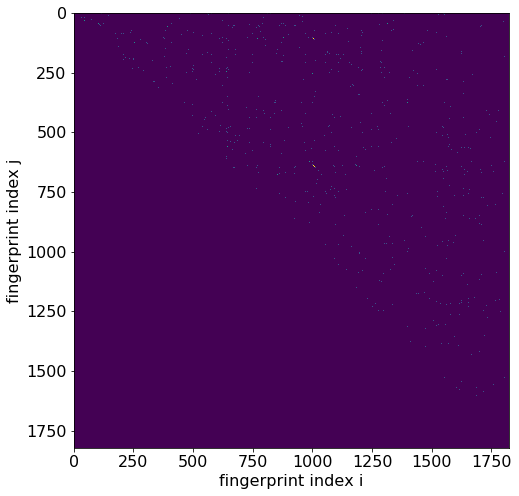

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(sim_matrix.todense(), vmin=0, vmax=4, aspect='equal')
plt.xlabel('fingerprint index i')
plt.ylabel('fingerprint index j')

#### Plot sum of detections along diagonals
##### Diagonal with many detections may indicate candidate earthquake-pair(s)

Text(0,0.5,'detection frequency')

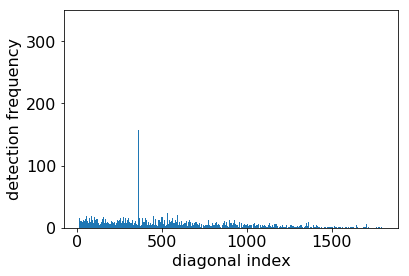

In [22]:
plt.figure()
plt.hist(dt_ij, bins=N)
plt.xlabel('diagonal index')
plt.ylabel('detection frequency')

#### Plot sum along similarity matrix rows/columns
##### Row/Column with many detections may indicate candidate earthquake

Text(0,0.5,'detection frequency')

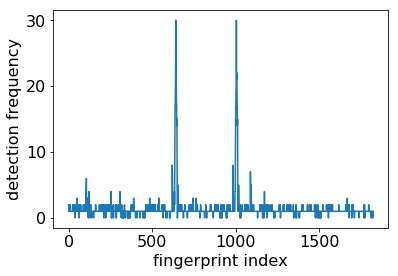

In [23]:
mprofile = np.array((sim_matrix + sim_matrix.T).max(axis=0).todense())[0,:]
plt.figure()
plt.plot(mprofile)
plt.xlabel('fingerprint index')
plt.ylabel('detection frequency')

#### Identify pairs of fingerprints with highest similarity

In [24]:
mpairs = np.array((sim_matrix + sim_matrix.T).argmax(axis=0))[0,:]
peaks, out = find_peaks(mprofile, height = np.sort(mprofile)[-30])
peaks
top_pairs = np.unique(np.sort(np.vstack( [ mpairs[peaks], peaks] ), axis=0), axis=1)
top_pairs.T

array([[ 620,  983],
       [ 641, 1004],
       [ 644, 1007],
       [ 648, 1011]])

### Plot waveforms, fingerprints of most similar pairs

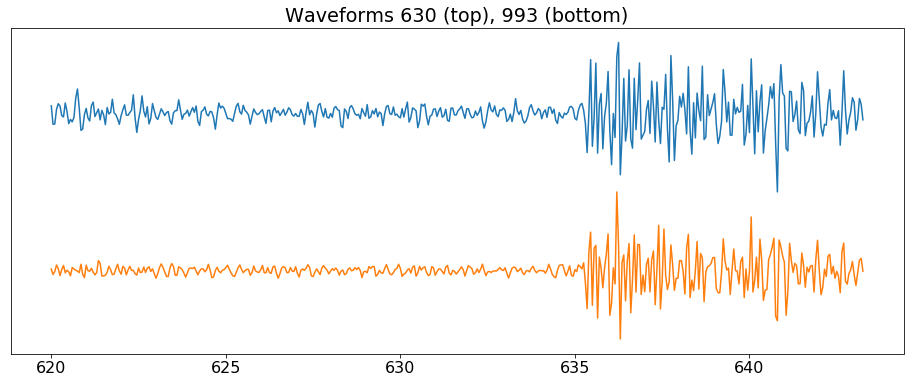

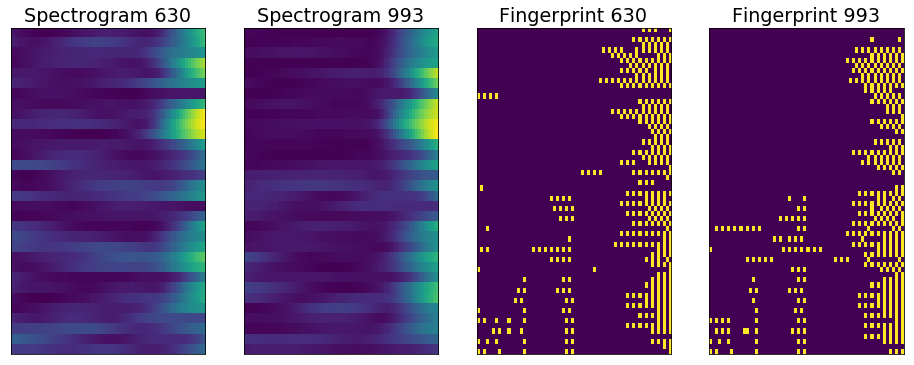

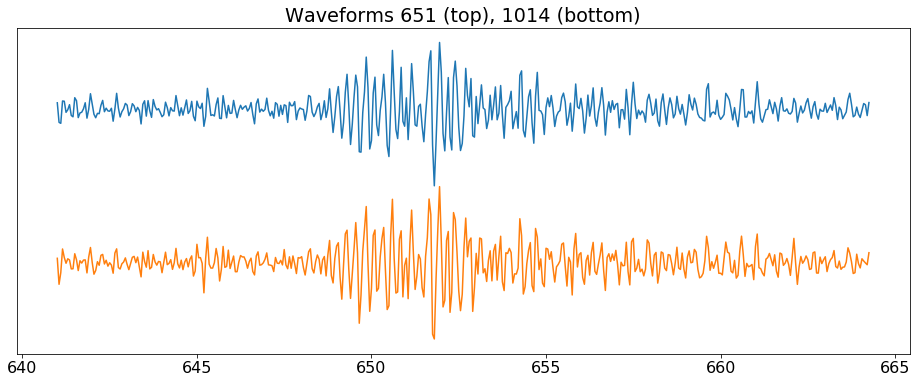

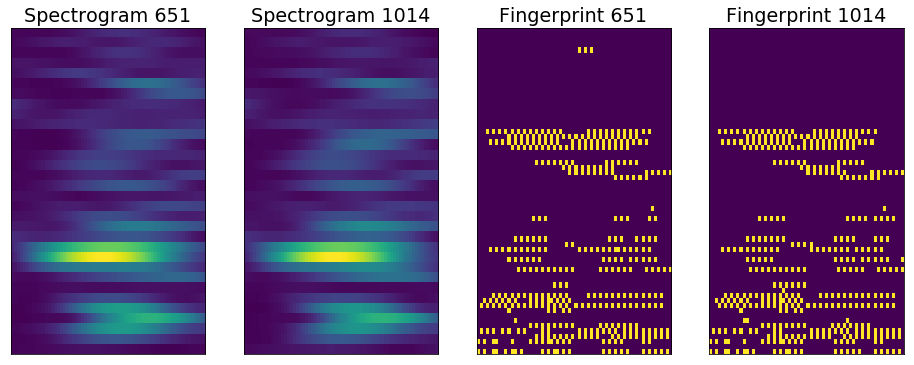

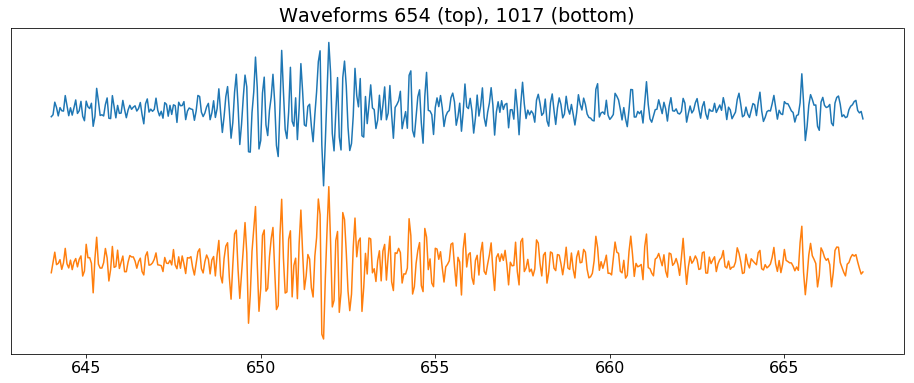

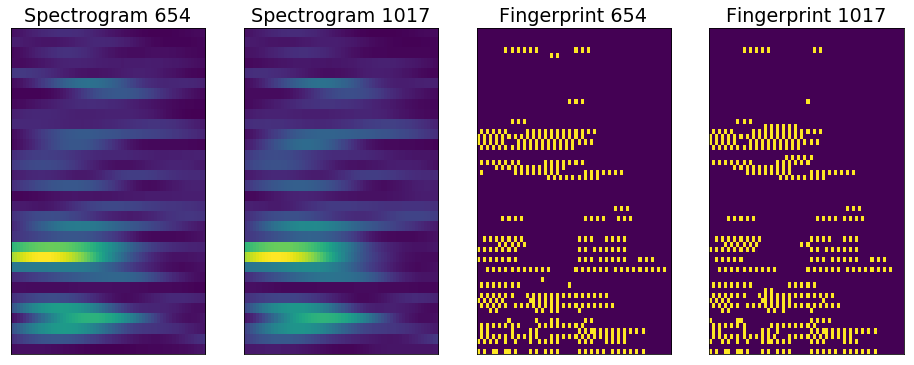

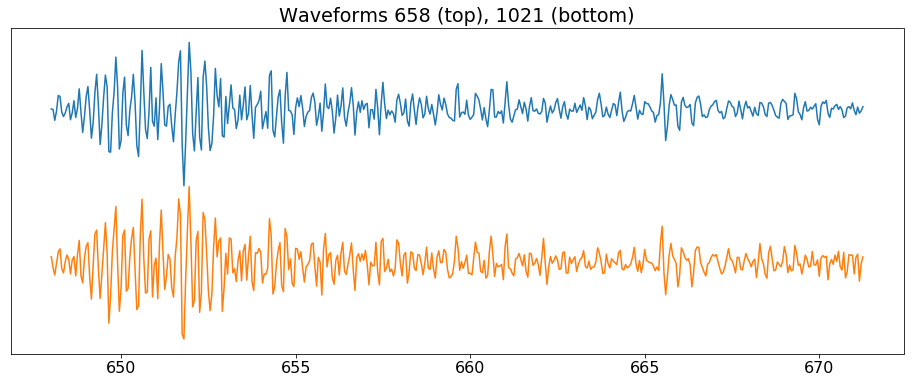

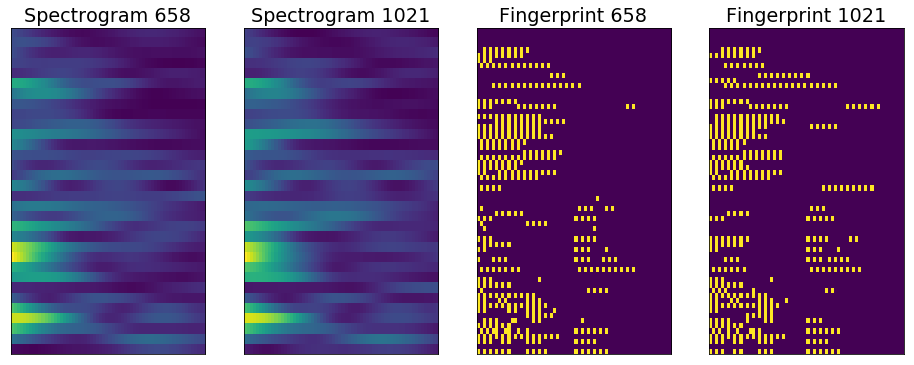

In [25]:
w1 = int((spec_winlen + fp_winlen)*sampling_rate / 2)
w2 = int((spec_winlen + fp_winlen)*sampling_rate * (2/3))
npairs = top_pairs.shape[1]
for k in range(npairs):
    iidx = top_pairs[0,k]
    jidx = top_pairs[1,k]
    tii = int(spec_t[iidx] * sampling_rate)
    tjj = int(spec_t[jidx] * sampling_rate)
    trace_t = t_trace[(tii-w1):(tii+w2)]
    trace_i = x_trace[(tii-w1):(tii+w2)]
    trace_j = x_trace[(tjj-w1):(tjj+w2)]
    plt.figure(figsize=(16,6))
    plt.plot(trace_t, (trace_i / np.abs(trace_i).max()) + 1)
    plt.plot(trace_t, (trace_j / np.abs(trace_j).max()) - 1)
    plt.yticks([])
    plt.title('Waveforms %1.0f (top), %1.0f (bottom)' % (spec_t[iidx], spec_t[jidx]))
    plt.show()
    f, ax = plt.subplots(1, 4, figsize=(16,6))
    ax[0].imshow(np.log(spec_images[iidx,:,:] + 0.01), aspect='auto', origin='lower')
    ax[0].set_title('Spectrogram %1.0f' % spec_t[iidx])
    ax[1].imshow(np.log(spec_images[jidx,:,:] + 0.01), aspect='auto', origin='lower') 
    ax[1].set_title('Spectrogram %1.0f' % spec_t[jidx])
    ax[2].imshow(binary_fp_bool[iidx,:].reshape(2*fp_dims[0], fp_dims[1]), aspect='auto', vmin=0, vmax=1, origin='lower')
    ax[2].set_title('Fingerprint %1.0f' % spec_t[iidx])
    ax[3].imshow(binary_fp_bool[jidx,:].reshape(2*fp_dims[0], fp_dims[1]), aspect='auto', vmin=0, vmax=1, origin='lower')
    ax[3].set_title('Fingerprint %1.0f' % spec_t[jidx])
    for axis in ax:
        axis.set_xticks([])
        axis.set_yticks([])
    plt.show()

### Randomized algorithm: LSH
#### Plot theoretical vs. empirical probability of detection

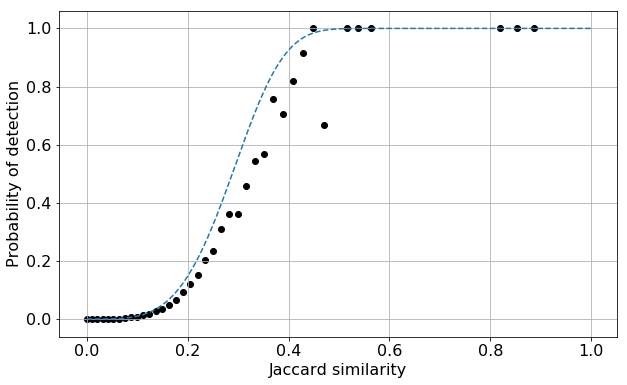

In [26]:
jvals = np.linspace(0, K, K+1) /  (2*K - np.linspace(0, K, K+1))
pvals = 1.0 - (1.0 - (jvals**nfunc))**ntabl

histD, bin_edges = np.histogram(np.triu(jaccard_sim, k=fp_nearrepeat).flatten(), bins = np.concatenate((jvals[0:K:8],[1.01])))
histN, bin_edges = np.histogram(jaccard_sim[sim_matrix.todense() > 0].flatten(), bins = np.concatenate((jvals[0:K:8],[1.01])))
prob_emp = np.zeros_like(histD, dtype=float)
prob_emp[histD > 0] = (1.0*histN[histD > 0]) / (1.0*histD[histD > 0])

plt.figure(figsize=(10,6))
plt.plot(jvals, pvals, '--')
plt.scatter(jvals[0:K:8][histD > 2], prob_emp[histD > 2], color='black')
plt.xlabel('Jaccard similarity')
plt.ylabel('Probability of detection')
plt.grid(True, zorder=0)